## DC2 Classification Accuracy

In [1]:
import torch
from pathlib import Path

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import sklearn.metrics

from hydra import initialize, compose
from hydra.utils import instantiate

from case_studies.dc2_cataloging.utils.load_full_cat import get_full_cat

output_dir = Path("./classification_accuracy_output/")
output_dir.mkdir(parents=True, exist_ok=True)

# change this model path according to your training setting
model_path = "../../../bliss_output/DC2_cataloging_exp_07/exp_07-06-5/checkpoints/best_encoder.ckpt"
lsst_root_dir = "/data/scratch/dc2_nfs/"

device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [2]:
with initialize(config_path=".", version_base=None):
    notebook_cfg = compose("notebook_config")

In [3]:
test_image_idx = 0
test_image, test_image_cat, bliss_full_cat, lsst_full_cat = get_full_cat(notebook_cfg, 
                                                             test_image_idx, 
                                                             model_path, 
                                                             lsst_root_dir, 
                                                             device)
image_lim = test_image.shape[1]
test_image = test_image[2]  # r-band

In [4]:
matcher = instantiate(notebook_cfg.encoder.matcher)
bliss_metrics = instantiate(notebook_cfg.encoder.metrics)
bliss_metrics = bliss_metrics["source_type_accuracy"]
lsst_metrics = bliss_metrics.clone()

flux_bin_cutoffs = bliss_metrics.flux_bin_cutoffs

bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])
lsst_matching = list(matcher.match_catalogs(test_image_cat, lsst_full_cat)[0])

bliss_metrics.update(test_image_cat, bliss_full_cat, [bliss_matching])
lsst_metrics.update(test_image_cat, lsst_full_cat, [lsst_matching])

bliss_internal_states = bliss_metrics.get_internal_states()
lsst_internal_states = lsst_metrics.get_internal_states()

In [5]:
def plot(bliss_internal_states,
         lsst_internal_states,
         flux_bin_cutoffs):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(
        1, 1, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax.bar_label(rects, padding=3, fontsize=6)
        multiplier += 1

    ax.set_ylabel("Count")
    ax.set_xlabel("Flux")
    ax.set_xticks(x + width)
    ax.set_xticklabels(xlabels, rotation=45)
    ax.set_yscale("log")
    ax.set_ylim(top=1e5)
    ax.grid(visible=False, axis="x")
    ax.legend(loc="upper right")
    
    ax2 = ax.twinx()

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    bliss_gal_f1,  = ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[4],
        label=f"BLISS F1",
    )
    lsst_gal_f1,  = ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[5],
        label=f"LSST F1",
    )

    # bliss_star_f1,  = ax2.plot(
    #     x + width,
    #     get_f1(bliss_internal_states, galaxy=False),
    #     "-o",
    #     color=color_list[6],
    #     label=f"BLISS F1 (Star)",
    # )
    # lsst_star_f1,  = ax2.plot(
    #     x + width,
    #     get_f1(lsst_internal_states, galaxy=False),
    #     "-o",
    #     color=color_list[7],
    #     label=f"LSST F1 (Star)",
    # )
    
    ax2.set_ylabel("Classification F1")
    ax2.grid(visible=False, axis="both")
    fig.legend(handles=[bliss_gal_f1, lsst_gal_f1], loc="outside upper center", ncols=2)

    return fig, ax

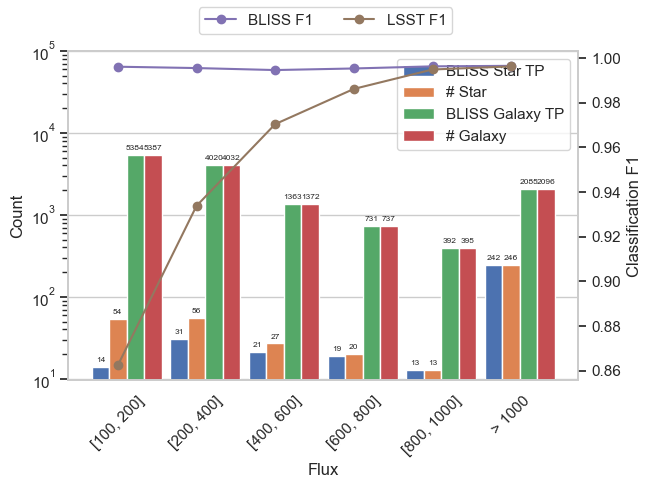

In [6]:
fig1, ax1 = plot(bliss_internal_states,
               lsst_internal_states,
               flux_bin_cutoffs=flux_bin_cutoffs)
fig1.savefig(output_dir / "classification_acc.pdf", bbox_inches="tight")
fig1.show()

In [11]:
def separate_plot(bliss_internal_states,
         lsst_internal_states,
         flux_bin_cutoffs):
    xlabels = (
        ["[100, " + str(flux_bin_cutoffs[0]) + "]"]
        + [f"[{flux_bin_cutoffs[i]}, {flux_bin_cutoffs[i + 1]}]" for i in range(len(flux_bin_cutoffs) - 1)]
        + ["> " + str(flux_bin_cutoffs[-1])]
    )

    bar_plot_data = {
        "BLISS Star TP": bliss_internal_states["star_tp"],
        "# Star": bliss_internal_states["n_matches"] - bliss_internal_states["gal_tp"] - bliss_internal_states["star_fp"],
        "BLISS Galaxy TP": bliss_internal_states["gal_tp"],
        "# Galaxy": bliss_internal_states["n_matches"] - bliss_internal_states["star_tp"] - bliss_internal_states["gal_fp"],
    }

    sns.set_theme(style="whitegrid")
    fig1, ax1 = plt.subplots(
        1, 1, layout="constrained"
    )
    color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    x = np.arange(len(xlabels)) * 45
    width = 10
    multiplier = 0

    for i, (data_name, data) in enumerate(bar_plot_data.items()):
        offset = width * multiplier
        rects = ax1.bar(x + offset, data, width, color=color_list[i], label=data_name)
        ax1.bar_label(rects, padding=3, fontsize=6)
        multiplier += 1

    ax1.set_ylabel("Count")
    ax1.set_xlabel("Flux")
    ax1.set_xticks(x + width)
    ax1.set_xticklabels(xlabels, rotation=45)
    ax1.set_yscale("log")
    ax1.set_ylim(top=1e5)
    ax1.grid(visible=False, axis="x")
    ax1.legend(loc="upper right")

    fig2, ax2 = plt.subplots(
        1, 1, layout="constrained"
    )

    def get_f1(internal_states, galaxy: bool):
        if galaxy:
            recall = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["star_fp"])
            precision = internal_states["gal_tp"] / (internal_states["gal_tp"] + internal_states["gal_fp"])
        else:
            recall = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["gal_fp"])
            precision = internal_states["star_tp"] / (internal_states["star_tp"] + internal_states["star_fp"])
        f1 = 2 * precision * recall / (precision + recall)
        return f1
    
    ax2.plot(
        x + width,
        get_f1(bliss_internal_states, galaxy=True),
        "-o",
        color=color_list[4],
        label=f"BLISS F1",
    )
    ax2.plot(
        x + width,
        get_f1(lsst_internal_states, galaxy=True),
        "-o",
        color=color_list[5],
        label=f"LSST F1",
    )
    
    ax2.set_ylabel("Classification F1")
    ax2.set_xlabel("Flux")
    ax2.set_xticks(x + width)
    ax2.set_xticklabels(xlabels, rotation=45)
    ax2.grid(visible=False, axis="x")
    ax2.legend()

    return fig1, ax1, fig2, ax2

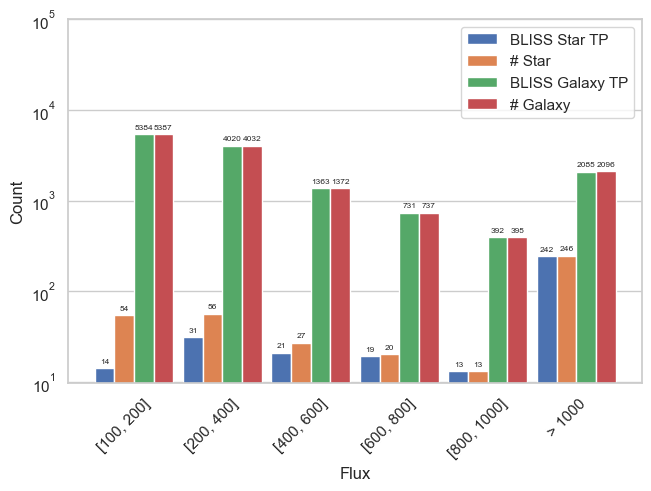

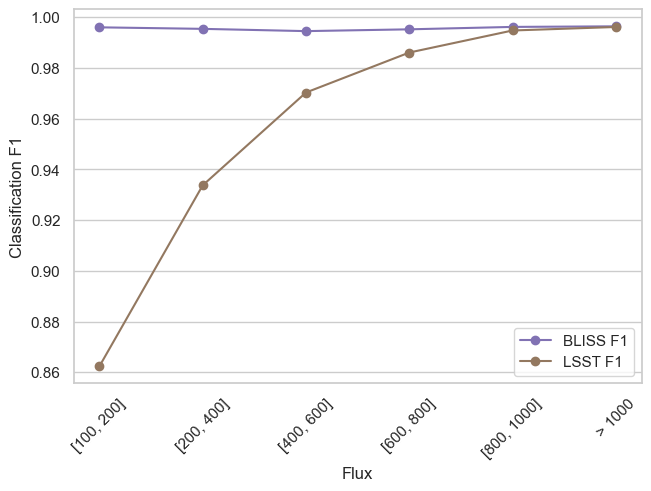

In [12]:
fig1, _, fig2, _ = separate_plot(bliss_internal_states,
                                    lsst_internal_states,
                                    flux_bin_cutoffs=flux_bin_cutoffs)
fig1.savefig(output_dir / "classification_acc_tp.pdf", bbox_inches="tight")
fig1.show()

fig2.savefig(output_dir / "classification_f1.pdf", bbox_inches="tight")
fig2.show()

In [ ]:
matcher = instantiate(notebook_cfg.encoder.matcher)
color_list = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plocs_box_len = 100
output_img_dir = output_dir / "images"
output_img_dir.mkdir(exist_ok=True)
for i in range(0, image_lim, plocs_box_len):
    for j in range(0, image_lim, plocs_box_len):
        plocs_box_origin = torch.tensor([i, j])

        cur_target_full_cat = test_image_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        cur_bliss_full_cat = bliss_full_cat.filter_full_catalog_by_ploc_box(plocs_box_origin, plocs_box_len)
        bliss_matching = matcher.match_catalogs(cur_target_full_cat, cur_bliss_full_cat)[0]

        true_fluxes = cur_target_full_cat.on_fluxes[0, bliss_matching[0].tolist(), 2].contiguous()  # r-band flux
        true_galaxy = cur_target_full_cat.galaxy_bools[0, bliss_matching[0].tolist(), 0]
        bliss_galaxy = cur_bliss_full_cat.galaxy_bools[0, bliss_matching[1].tolist(), 0]
        cur_target_plocs = cur_target_full_cat["plocs"][0, bliss_matching[0].tolist()]

        missing_match = (true_galaxy != bliss_galaxy)
        if missing_match.sum().item() == 0:
            continue

        galaxy_missing_match = (missing_match & true_galaxy)
        star_missing_match = (missing_match & (~true_galaxy))

        fig1, ax1 = plt.subplots(figsize=(8, 8))
        image_sub = test_image[i:(i + plocs_box_len), j:(j + plocs_box_len)]
        ax1.imshow(np.log((image_sub - image_sub.min()) + 80), cmap="viridis")
        missclassified_galaxy_x = cur_target_plocs[galaxy_missing_match, 1].tolist()
        missclassified_galaxy_y = cur_target_plocs[galaxy_missing_match, 0].tolist()
        missclassified_galaxy_flux = true_fluxes[galaxy_missing_match].tolist()
        ax1.scatter(missclassified_galaxy_x, 
                   missclassified_galaxy_y, 
                   facecolors="none", edgecolors=color_list[0], 
                   alpha=1, s=130, linewidth=3, label="Missclassified Galaxy")
        for flux, x, y in zip(missclassified_galaxy_flux, missclassified_galaxy_x, missclassified_galaxy_y):
            ax1.annotate(f"flux: {flux:.3g}", (x, y), textcoords="offset points", xytext=(5, 5), ha="center",
                        fontsize=12, color="lightgrey", fontweight="bold")

        missclassified_star_x = cur_target_plocs[star_missing_match, 1].tolist()
        missclassified_star_y = cur_target_plocs[star_missing_match, 0].tolist()
        missclassified_star_flux = true_fluxes[star_missing_match].tolist()
        ax1.scatter(missclassified_star_x, 
                   missclassified_star_y, 
                   facecolors="none", edgecolors=color_list[1], 
                   alpha=1, s=130, linewidth=3, label="Missclassified Star")
        for flux, x, y in zip(missclassified_star_flux, missclassified_star_x, missclassified_star_y):
            ax1.annotate(f"flux: {flux:.3g}", (x, y), textcoords="offset points", xytext=(5, 5), ha="center",
                        fontsize=12, color="lightgrey", fontweight="bold")

        ax1.legend()
        fig1.savefig(output_img_dir / f"image_{test_image_idx}_{i}_{j}.pdf", bbox_inches="tight")
        plt.close()

In [ ]:
bliss_matching = list(matcher.match_catalogs(test_image_cat, bliss_full_cat)[0])

true_galaxy = (test_image_cat["source_type"][0, bliss_matching[0].tolist(), 0] == 1)
est_galaxy_probs = bliss_full_cat["source_type_probs"][0, bliss_matching[1].tolist(), 1]

fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_galaxy, est_galaxy_probs)
roc_auc = sklearn.metrics.auc(fpr, tpr)

fig1, ax1 = plt.subplots(figsize=(8, 8))
ax1.plot(fpr, tpr, label=f"BLISS Classification Acc (AUC ={roc_auc: .3f})")
ax1.legend()
ax1.set_xlabel("False Positive Rate")
ax1.set_ylabel("True Positive Rate")
fig1.savefig(output_dir / "roc_plot.pdf", bbox_inches="tight")
fig1.show()